In [31]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [32]:
nbin = 58 ## number of binaries in sample
nvar = 5

## read in delK, parallax
delk = np.zeros(nbin)
edelk = np.zeros(nbin)
plxval = np.zeros(nbin)
plxprior = np.zeros(nbin)
name = strs = ['']*nbin
k = np.zeros(nbin)
ek = np.zeros(nbin)
feh = np.zeros(nbin)
f = open('data2.txt','r')
header1 = f.readline()
i=0
for line in f:
    line = line.strip()
    columns = line.split()
    name[i] = columns[0]
    delk[i] = float(columns[1])
    edelk[i] = float(columns[2])
    plxval[i] = float(columns[3])
    plxprior[i] = float(columns[4])
    k[i] = float(columns[5])
    ek[i] = float(columns[6])
    feh[i] = float(columns[8])
    i+=1
f.close()

## now for the sma**3/per**2
f = open('fits.txt','r')
header1 = f.readline()
i=0
smaper = np.zeros(nbin)
esmaper = np.zeros(nbin)
for line in f:
    line = line.strip()
    columns = line.split()
    smaper[i] = float(columns[0])
    esmaper[i] = float(columns[1])
    i+=1
f.close()

fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)


result_ben = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032]) # benedict fit value
result1 = np.array([0.23323026,-0.10887911, 0.019990399, 0.00027286744, -0.00046073982])# Mann fit value
result2 = plxval
result_delf = [0.001*1.8,0.001*6.12,0.001*13.205,-6.2315*0.001,0.001*0.37529]
result3= np.array([-0.663541,-0.212175 , 0.00594868 ,  0.00641549, -0.000416446]) ## one I measured in IDL
result3= np.array([-0.66354114,-0.21217510,0.0059486800,0.0064154901,-0.00041644563])
fehcoeff = np.array([0.01])
result = np.concatenate([result3[0:4],fehcoeff,result2])
#print result3[0:4]

In [33]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
empmass = factor*smaper/plxval**3
e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)

In [34]:
def lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar):
    zp = 7.5e0
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    a, b, c, d, f = theta[0:nvar]
    mplx = theta[nvar:theta.size]
    if np.min(mplx) <= 0:
        return -np.inf
    factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
    empmass = factor*smaper/mplx**3
    e_empmass = empmass*(esmaper/smaper)**2
    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.)
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.)
    mka -= zp
    mkb -= zp
    mass1 = (10.0**(a + b*mka + c*mka**2. + d*mka**3.))*(1+f*feh)
    mass2 = (10.0**(a + b*mkb + c*mkb**2. + d*mkb**3.))*(1+f*feh)
    if np.min(mass1) <= 0 or np.min(mass2) <= 0:
        return -np.inf
    
    ## this is where we check to see if the relation always does brighter=higher mass (if not return -np.inf)
    rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
    mk = np.linspace(4.0,11.1,100)
    l = 10.0**(a + b*mk + c*mk**2. + d*mk**3.)
    check = all(l[i] >= l[i+1] for i in xrange(len(l)-1))
    if not check:
        return -np.inf
    ## there's a better way to do this... probably to check to see if the slope goes negative

    mka_err = ekp
    mkb_err = eks
    mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2))*mass1*mka_err)
    mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2))*mass2*mkb_err)
    
    model_err = np.sqrt(mass1_err**2+mass2_err**2)
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [35]:
def lnprior(theta, plxval, plxprior, nvar):
    mplx = theta[nvar:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    for i in range(0,len(mplx)):
        lp += ((np.float(mplx[i])-np.float(plxval[i]))**2)/(np.float(plxprior[i])**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [36]:
def lnprob(theta, plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar):
    lp = lnprior(theta, plxval, plxprior, nvar)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar)
    if not np.isfinite(like):
        return -np.inf
    val = lp + like
    return val

In [37]:
import time
start_time = time.time()
ndim, nwalkers = result.size, 500
pos = [result + 1e-2*result*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar),
                               threads=6)
## burn-in and/or testing
smallstep = 5000
bigstep = 100000
pos, prob, state = sampler.run_mcmc(pos, smallstep)
print 'Finished burn/test phase runtime (minutes):'
print (time.time() - start_time)/60
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print 'Expected time (hours):'
print ((time.time() - start_time)/60)*(bigstep/smallstep)/60


Finished burn/test phase runtime (minutes):
14.7898757974
Mean acceptance fraction: 0.000
Expected time (hours):
4.93007179366


In [38]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat
best = (like == max(like))
a = arr[best,0:nvar]#np.median(arr[:,0])
print a

[[-0.6633764  -0.20646506  0.00591471  0.00626273  0.00981653]
 [-0.6633764  -0.20646506  0.00591471  0.00626273  0.00981653]
 [-0.6633764  -0.20646506  0.00591471  0.00626273  0.00981653]
 ..., 
 [-0.66111602 -0.21275264  0.00589426  0.00633262  0.01010188]
 [-0.66111602 -0.21275264  0.00589426  0.00633262  0.01010188]
 [-0.66111602 -0.21275264  0.00589426  0.00633262  0.01010188]]


In [9]:
sampler.reset()
start_time = time.time()
nsteps = bigstep
thin = 100
kwargs = {'thin': thin }
print 'Starting run!'
for i, result in enumerate(sampler.sample(pos, iterations=nsteps, **kwargs)):
    if (i+1) % 50000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps)),
        ("{0:5.2%}".format((time.time() - start_time)/60))
print ' '
print 'Done, runtime (hours):'
print (time.time() - start_time)/3600
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Starting run!
50.0% 100.0%  
Done, runtime (hours):
4.93452859302
Mean acceptance fraction: 0.000


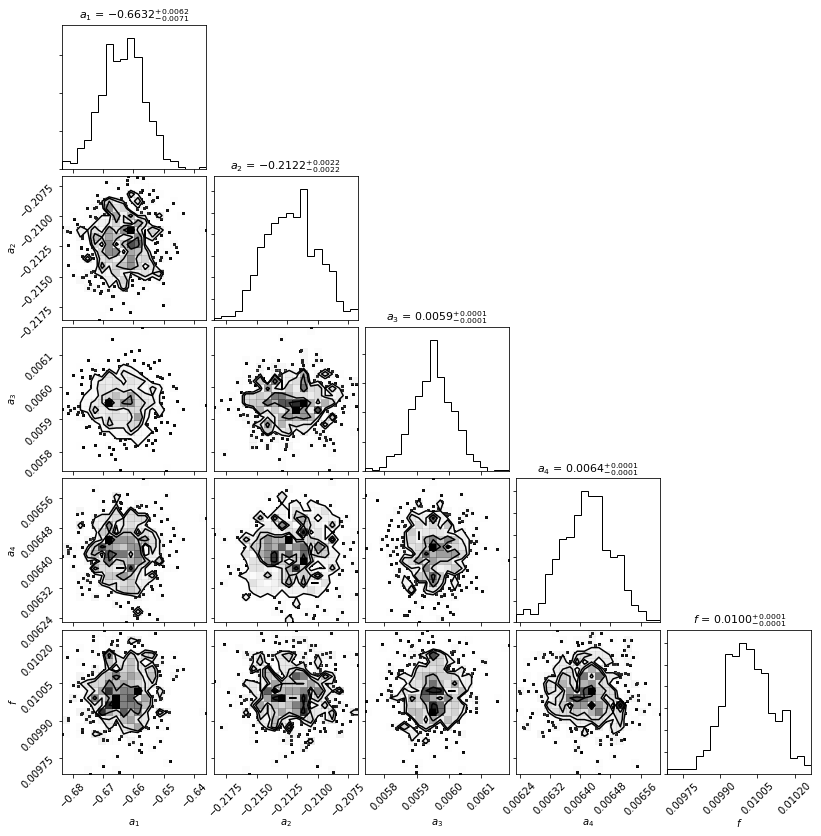

In [10]:
#print dat.shape,nwalkers,nsteps,thin
import corner
from matplotlib.backends.backend_pdf import PdfPages
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat

fig = corner.corner(arr[:,0:nvar], labels=[r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$f$'], show_titles=True, title_kwargs={"fontsize": 11},title_fmt='.4f')
pp = PdfPages('output_params_feh.pdf')
pp.savefig(fig)
pp.close()

In [11]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
print 'name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2'
for i in range(nvar,dat.shape[2]):
    print "{:10s}".format(name[i-nvar]), \
    i,\
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-nvar]), \
    "{0:.4f}".format(plxval[i-nvar]),"{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/plxprior[i-nvar]), \
    "{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/np.sqrt(plxprior[i-nvar]**2+np.std(arr[:,i])**2))
    

name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2
GJ623      5 125.0072 1.1625 0.3000 125.0000 -0.0242 -0.0060
GJ4024     6 50.0900 0.4991 2.5000 50.1000 0.0040 0.0039
PMJ02133+3648 7 74.6102 0.7492 3.5000 74.6000 -0.0029 -0.0028
HIP11542   8 38.2415 0.3657 1.6000 38.2000 -0.0259 -0.0253
HD239960   9 249.9210 2.5004 1.9000 249.9000 -0.0111 -0.0067
HD15285    10 58.3176 0.5701 1.1000 58.3000 -0.0160 -0.0142
Gl844      11 61.7622 0.6260 2.2000 61.8000 0.0172 0.0165
HIP9724    12 109.5290 1.1077 1.8700 109.5900 0.0326 0.0281
Gl831      13 125.2861 1.2032 0.3000 125.3000 0.0464 0.0112
Gl804      14 47.3962 0.4748 2.1000 47.4000 0.0018 0.0017
Gl747      15 122.2517 1.1412 2.5000 122.3000 0.0193 0.0176
Gl695C     16 120.3351 1.1925 0.1600 120.3300 -0.0318 -0.0042
Gl660      17 85.1841 0.8309 2.4700 85.2300 0.0186 0.0176
Gl54       18 126.8735 1.1978 0.4000 126.9000 0.0661 0.0209
Gl494      19 85.4721 0.8897 1.5000 85.5000 0.0186 0.0160
Gl473      20 227.8819 2.2732 4.6000 227

In [12]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
mass = factor*smaper/plxval**3

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
f = arr[best,5]
print a,b,c,d,f

mass1 = (10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3))*(1+f*feh)
mass2 = (10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3))*(1+f*feh)
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_mann = mass1+mass2
a, b, c, d, e = result_ben
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

[-0.65703732 -0.65703732 -0.65703732 ..., -0.65996396 -0.65996396
 -0.65996396] [-0.20788549 -0.20788549 -0.20788549 ..., -0.21295932 -0.21295932
 -0.21295932] [ 0.00592157  0.00592157  0.00592157 ...,  0.00589023  0.00589023
  0.00589023] [ 0.00643949  0.00643949  0.00643949 ...,  0.00646237  0.00646237
  0.00646237] [ 124.03434853  124.03434853  124.03434853 ...,  127.61055846  127.61055846
  127.61055846]


ValueError: operands could not be broadcast together with shapes (500000,) (58,) 

In [ ]:
print sampler.chain.shape
print sampler.lnprobability.shape
short = sampler.chain[:,:,0:nvar]
print short.shape
#print np.median(sampler.chain[:,:,5])

In [ ]:
## save out the relevant chains
import pyfits
pyfits.writeto('Mk-Mass_feh4_emcee.fits', sampler.chain, clobber=True)
pyfits.writeto('Mk-Mass_feh4_emcee_short.fits', short, clobber=True)
pyfits.writeto('Mk-Mass_feh4_emcee_accept.fits', sampler.acceptance_fraction, clobber=True)
pyfits.writeto('Mk-Mass_feh4_emcee_lnprob.fits', sampler.lnprobability, clobber=True)
pyfits.writeto('Mk-Mass_feh4_emcee_acor.fits', sampler.acor, clobber=True)